In [238]:
import math
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing

In [239]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [240]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [241]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 9, 3)

df = web.DataReader("TSLA", 'yahoo', start, end)
df.tail()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-08-28,463.697998,437.303986,459.023987,442.679993,100406000.0,442.679993
2020-08-31,500.140015,440.109985,444.609985,498.320007,118374400.0,498.320007
2020-09-01,502.489990,470.510010,502.140015,475.049988,90119400.0,475.049988
2020-09-02,479.040009,405.119995,478.989990,447.369995,96176100.0,447.369995
2020-09-03,431.799988,402.000000,407.230011,407.000000,87596100.0,407.000000


In [242]:
df.shape 

(2565, 6)

In [243]:
# Calculating the mean-average over 100 day rolling window
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail()


Date
2020-08-28    232.164099
2020-08-31    236.049619
2020-09-01    239.654119
2020-09-02    242.825919
2020-09-03    245.476139
Name: Adj Close, dtype: float64

In [244]:
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

In [245]:
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))



In [246]:
style.use('ggplot')

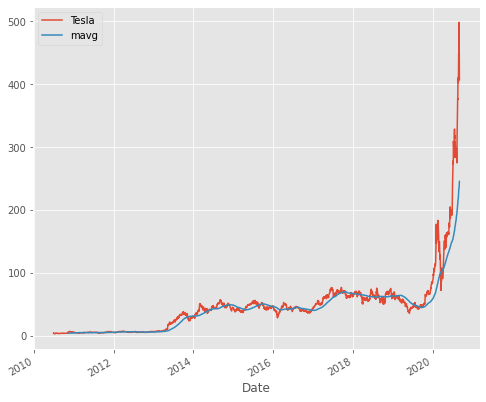

In [247]:
close_px.plot(label='Tesla')
mavg.plot(label='mavg')
plt.legend()


In [248]:
dfcomp = web.DataReader(['TSLA', 'AMZN', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()




Symbols,TSLA,AMZN,GOOG,IBM,MSFT
Date,,,,,
2020-08-28,442.679993,3401.800049,1644.410034,123.282341,228.312271
2020-08-31,498.320007,3450.959961,1634.180054,121.547493,224.941086
2020-09-01,475.049988,3499.120117,1660.709961,121.636215,226.676559
2020-09-02,447.369995,3531.449951,1728.280029,126.347885,231.045105
2020-09-03,407.000000,3368.000000,1641.839966,122.671204,216.732590


In [249]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr.tail()

Symbols,TSLA,AMZN,GOOG,IBM,MSFT
Symbols,,,,,
TSLA,1.000000,0.311572,0.305625,0.249018,0.314286
AMZN,0.311572,1.000000,0.573572,0.372127,0.516438
GOOG,0.305625,0.573572,1.000000,0.472892,0.605615
IBM,0.249018,0.372127,0.472892,1.000000,0.550349
MSFT,0.314286,0.516438,0.605615,0.550349,1.000000


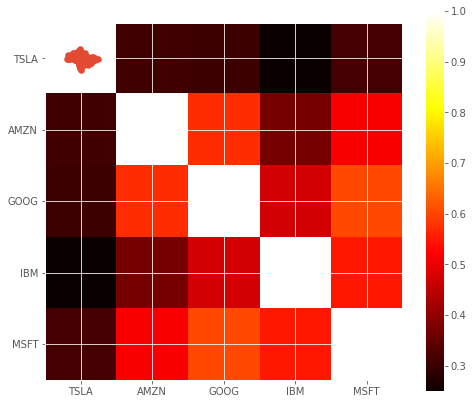

In [250]:
plt.scatter(retscomp.TSLA, retscomp.AMZN)


plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

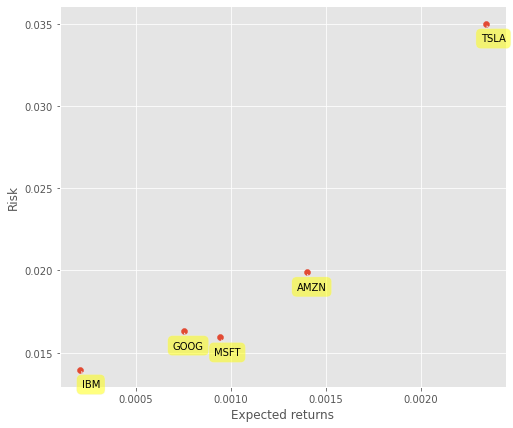

In [251]:
#Plotting the risk-return graph for the given stocks(https://www.sarsaonline.com/risk-return-graph/#:~:text=The%20risk%2Freturn%20graph%20is,part%20of%20risk%2Dreturn%20graph.)

plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [252]:
#calculating the percentage change in the opening and closing of the stock change 
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()


,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2020-08-28,442.679993,100406000.0,5.962323,-3.560597
2020-08-31,498.320007,118374400.0,12.046482,12.080255
2020-09-01,475.049988,90119400.0,6.731919,-5.394915
2020-09-02,447.369995,96176100.0,16.523239,-6.601390
2020-09-03,407.000000,87596100.0,7.321864,-0.056482


In [253]:
# Now, we need to clean data by removing NaN value 
dfreg.fillna(value=-99999, inplace=True)


In [254]:
# Let's forecast by sepearating 1 percent of the data 
forecast_out = int(math.ceil(0.01 * len(dfreg)))

In [255]:
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
# Let's shifts the dataframe index with an optimal time frequency 
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [256]:
#Scaling the X so that we have same distribution for every stock in linear regression 
X = preprocessing.scale(X)


In [257]:
# Let's sepearate the recent stock trends by denoting it as X_late and early stock trend by denoting as X_early; so as to do prediction and evaluation for the stock 
X_late = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [258]:
#Sepearating the stocks into training and testing model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [259]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [260]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [261]:
# prints confidence scores for each algorithm:

print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)

The linear regression confidence is  0.891041598196793
The quadratic regression 2 confidence is  0.9092946524812573
The quadratic regression 3 confidence is  0.8906990630407994
The knn regression confidence is  0.8320620127111671


In [262]:

forecast_set = clfknn.predict(X_late)

last_date = datetime.date(2021, 6,21)
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)
print(last_date)
print(next_unix)

2021-06-21
2021-06-22


In [263]:
algorithms = [clfreg, clfpoly2, clfpoly3, clfknn]


dfreg['Forecast'] = np.nan

last_date = datetime.date(2020, 6, 21)
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)


The confidence score is  0.891041598196793


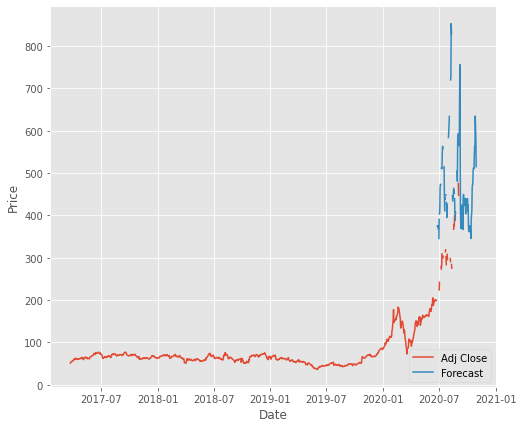

The confidence score is  0.9092946524812573


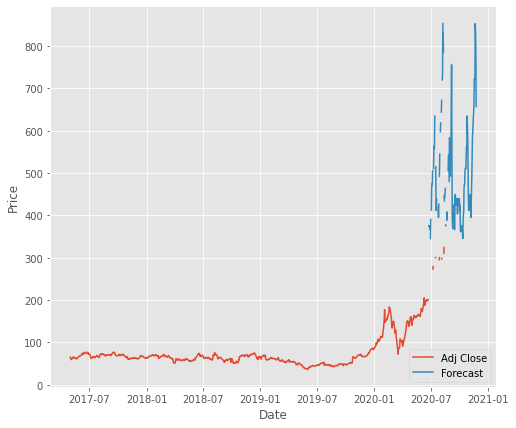

The confidence score is  0.8906990630407994


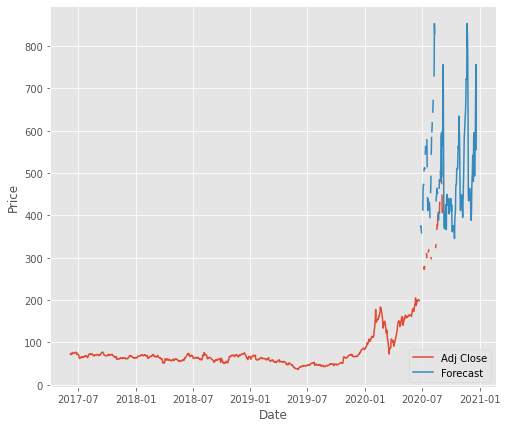

The confidence score is  0.8320620127111671


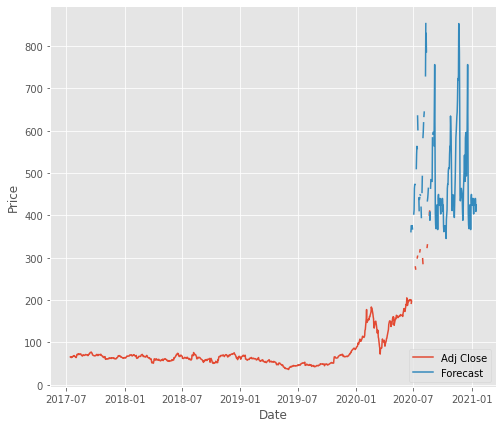

In [265]:
for x in algorithms:
  forecast_set = x.predict(X_late)
  print('The confidence score is ', x.score(X_test,y_test))

  for i in forecast_set:
      next_date = next_unix
      next_unix += datetime.timedelta(days=1)
      dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
  dfreg['Adj Close'].tail(1000).plot()
  dfreg['Forecast'].tail(1000).plot()
  plt.legend(loc=4)
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.show()